Machine Learning Assignment 2 
# Sign Shape Model

In [2]:
# imports
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob



In [3]:
# setup data 
image_list = []
    # -3 means back one directory
# filename/shape/type/label
for filepath in glob.glob('images/*/*/*.png', recursive=True):
     filename = filepath.split("\\")[-1]
     sign_shape = filepath.split("\\")[-2]
     sign_type = filepath.split("\\")[-3]
     
     image_list.append((filepath,sign_shape,sign_type))
     
data = pd.DataFrame(data=image_list, columns=['image_path','sign_type', 'sign_shape'])


Dataframes for training and validation

In [4]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

# plt.figure(figsize=(16,4))
# for i, image_path in enumerate(rand_data):
#     im = np.asarray(Image.open(image_path))
#     plt.subplot(1,4,i+1)
#     plt.imshow(im,cmap='gray')
#     plt.axis('off')
#     
# plt.show()

d = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
data['shapes_num'] = data['sign_shape'].map(d, na_action='ignore')


# 80% train 20% test 20%validation
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
print("Train")
print(train)
print("test")
print(test)
print("validate")
print(validate)

N_train_images = train.shape[0]
N_val_images = validate.shape[0]
N_test_images = test.shape[0]




Train
                                     image_path   sign_type sign_shape  \
1341     images\round\noparking\01822_00001.png   noparking      round   
606        images\round\bicycle\01961_00002.png     bicycle      round   
160   images\diamond\rightofway\01262_00001.png  rightofway    diamond   
3673    images\triangle\warning\01880_00000.png     warning   triangle   
3496    images\triangle\warning\01291_00001.png     warning   triangle   
...                                         ...         ...        ...   
1353    images\round\roundabout\00099_00001.png  roundabout      round   
48    images\diamond\rightofway\00121_00002.png  rightofway    diamond   
1558         images\round\speed\00959_00001.png       speed      round   
208   images\diamond\rightofway\01588_00002.png  rightofway    diamond   
2912    images\triangle\giveway\01204_00002.png     giveway   triangle   

      shapes_num  
1341           2  
606            2  
160            0  
3673           4  
3496      

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_crossentropy, sparse_categorical_accuracy


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from keras.layers import GaussianNoise

sgd = optimizers.SGD(lr=0.01, decay=0.001, momentum=0.9, nesterov=True)

model_cnn = Sequential()

# input
model_cnn.add(Input(shape=(28, 28, 3)))
model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights


# CONV => RELU => BN => POOL
model_cnn.add(Conv2D(8, (5, 5),kernel_regularizer=regularizers.l2(0.001), padding='same'))
model_cnn.add(Activation("relu"))

model_cnn.add(Conv2D(8, (5, 5),kernel_regularizer=regularizers.l2(0.001), padding='same'))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(8, (5, 5),kernel_regularizer=regularizers.l2(0.001), padding='same'))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(8, (5, 5),kernel_regularizer=regularizers.l2(0.001), padding='same'))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model_cnn.add(Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
# model_cnn.add(Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
# model_cnn.add(Activation("relu"))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 
# model_cnn.add(Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
# model_cnn.add(Activation("relu"))
# model_cnn.add(Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
# model_cnn.add(Activation("relu"))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))


model_cnn.add(Flatten())
model_cnn.add(Dense(32,kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
# second set of FC => RELU layers
model_cnn.add(Dense(32,kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())


# # second set of FC => RELU layers
# model_cnn.add(Flatten())
# model_cnn.add(Dense(60))
# model_cnn.add(Activation("relu"))
# model_cnn.add(BatchNormalization())



model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))



model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         1608      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
                                
                                   
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 120
# 72 works

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validate,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False
)



Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [8]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0

    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because the generator loops indefinitely
            break

    return np.mean(loss_hold), np.mean(acc_hold)


In [9]:
def train_model(model_, num_epoch=140, verbose=True):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))

    model_.save('model1.h5')
    print('Model saved')

    return np.asarray(res)

In [10]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

res = train_model(model_cnn, num_epoch=140, verbose=True)
# model_cnn.fit_generator(train_generator,
#                               validation_data=validation_generator, epochs=30)
# model_cnn.save_weights('first_try.h5')

Training epoch 0: Loss = 1.7206932306289673, Accuracy = 0.34568095207214355
Validation epoch 0: Loss = 1.4591781082607451, Accuracy = 0.49047619104385376
Training epoch 1: Loss = 1.2831107378005981, Accuracy = 0.5749564170837402
Validation epoch 1: Loss = 1.3761060249237786, Accuracy = 0.5035713911056519
Training epoch 2: Loss = 1.0728497505187988, Accuracy = 0.6528205871582031
Validation epoch 2: Loss = 1.409085506484622, Accuracy = 0.4583333134651184
Training epoch 3: Loss = 1.0035046339035034, Accuracy = 0.6650535464286804
Validation epoch 3: Loss = 1.2750724463235765, Accuracy = 0.5488095283508301
Training epoch 4: Loss = 0.9225453734397888, Accuracy = 0.6953729391098022
Validation epoch 4: Loss = 1.179978022688911, Accuracy = 0.5666667222976685
Training epoch 5: Loss = 0.8494312167167664, Accuracy = 0.7338144183158875
Validation epoch 5: Loss = 1.0088242479733058, Accuracy = 0.6773809790611267
Training epoch 6: Loss = 0.8490415811538696, Accuracy = 0.7305265069007874
Validation ep

In [11]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


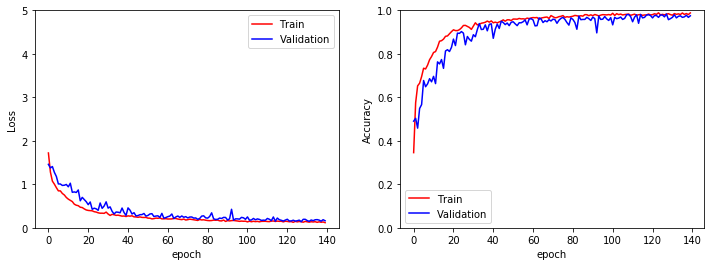

In [12]:
plot_results(res)

In [28]:
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
import seaborn as sn


pred = model_cnn.predict(test_generator)
print(np.argmax(pred[0]))

predicted_class_indices=np.argmax(pred,axis=1)

print(test_generator)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]


1
     Filename  Predictions
0           1            1
1           3            3
2           2            2
3           4            4
4           2            2
..        ...          ...
735         2            2
736         2            2
737         4            4
738         2            2
739         3            3

[740 rows x 2 columns]
  ...
    to  
  ['...']
7/7 [==============================] - 1s 206ms/step - loss: 0.1359 - accuracy: 0.9851
[0.13589852729013988, 0.98513514]


Results on test data

In [ ]:
# TODO load model for easier testing

In [29]:
# test classes
test_classes = np.array(test_generator.classes)

test_labels = test_generator.class_indices
test_labels = dict((v,k) for k,v in test_labels.items())

test_class = [test_labels[k] for k in test_classes]


filenames=test_generator.classes

results=pd.DataFrame({"Filename":test_classes,
                      "Predictions":predicted_class_indices})
print(results)


tests = model_cnn.evaluate(test_generator)
print(tests)

     Filename  Predictions
0           1            1
1           3            3
2           2            2
3           4            4
4           2            2
..        ...          ...
735         2            2
736         2            2
737         4            4
738         2            2
739         3            3

[740 rows x 2 columns]
  ...
    to  
  ['...']
7/7 [==============================] - 1s 96ms/step - loss: 0.1359 - accuracy: 0.9851
[0.13589852729013988, 0.98513514]


## loss: 0.1359 - accuracy: 0.9851 on testing 
 now for...
# Real World Data

In [83]:
from PIL import Image
from resizeimage import resizeimage

image_list = []
    # -3 means back one directory
# filename/shape/type/label
for filepath in glob.glob('Test/*/*.png', recursive=True):
     filename = filepath.split("\\")[-1]
     sign_shape = filepath.split("\\")[-2]
     
     image_list.append((filepath,sign_shape))
     
real_word_data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape'])


real_world_d = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
real_word_data['shapes_num'] = real_word_data['sign_shape'].map(d, na_action='ignore')

print(real_word_data)

# grey scale
for image_path in real_word_data['image_path']:
    img = Image.open(image_path).convert('LA')
    img.save(image_path)


# Resize images
for image_path in real_word_data['image_path']:
    with open(image_path, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_cover(image, [28, 28])
            cover.save(image_path, image.format)


Test\diamond\00012_00000_00001.png
Test\diamond\00012_00000_00002.png
Test\diamond\00012_00000_00003.png
Test\diamond\00012_00000_00004.png
Test\diamond\00012_00000_00005.png
Test\diamond\00012_00000_00006.png
Test\diamond\00012_00000_00007.png
Test\diamond\00012_00000_00008.png
Test\diamond\00012_00000_00009.png
Test\diamond\00012_00000_00010.png
Test\diamond\00012_00000_00011.png
Test\diamond\00012_00000_00012.png
Test\diamond\00012_00000_00013.png
Test\diamond\00012_00000_00014.png
Test\diamond\00012_00000_00015.png
Test\diamond\00012_00000_00016.png
Test\diamond\00012_00000_00017.png
Test\diamond\00012_00000_00018.png
Test\diamond\00012_00000_00019.png
Test\diamond\00012_00000_00020.png
Test\diamond\00012_00000_00021.png
Test\diamond\00012_00000_00022.png
Test\diamond\00012_00000_00023.png
Test\diamond\00012_00000_00024.png
Test\diamond\00012_00000_00025.png
Test\diamond\00012_00000_00026.png
Test\diamond\00012_00000_00027.png
Test\diamond\00012_00000_00028.png
Test\diamond\00012_0

In [84]:
#Image Setup

real_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


real_test_generator = real_test_datagen.flow_from_dataframe(
        dataframe=real_word_data,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False
)



real_pred = model_cnn.predict(real_test_generator)


real_predicted_class_indices=np.argmax(real_pred,axis=1)

# test classes
real_test_classes = np.array(real_test_generator.classes)

real_test_labels = real_test_generator.class_indices
real_test_labels = dict((v,k) for k,v in real_test_labels.items())

real_test_class = [real_test_labels[k] for k in real_test_classes]


filenames=real_test_generator.classes

results=pd.DataFrame({"Filename":real_test_classes,
                      "Predictions":real_predicted_class_indices})
print(results)


tests = model_cnn.evaluate(real_test_generator)
print(tests)

Found 342 validated image filenames belonging to 5 classes.
     Filename  Predictions
0           0            0
1           0            0
2           0            0
3           0            0
4           0            2
..        ...          ...
337         4            4
338         4            4
339         4            4
340         4            4
341         4            4

[342 rows x 2 columns]
  ...
    to  
  ['...']
3/3 [==============================] - 0s 111ms/step - loss: 0.7815 - accuracy: 0.8012
[0.7815323869387308, 0.8011696]


loss: 0.7815 - accuracy: 0.8012
